In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [5]:
image_dir = r'C:\Users\DELL\Desktop\python project\Deep Learning\Wildfire Detection\forest_fire'

In [6]:
from pathlib import Path

In [7]:
def convert_path_to_df(image_dir):
    image_dir = Path(image_dir)
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(image_dir)

In [8]:
image_df.head()

,Filepath,Label
0,C:\Users\DELL\Desktop\python project\Deep Lear...,fire
1,C:\Users\DELL\Desktop\python project\Deep Lear...,fire
2,C:\Users\DELL\Desktop\python project\Deep Lear...,fire
3,C:\Users\DELL\Desktop\python project\Deep Lear...,fire
4,C:\Users\DELL\Desktop\python project\Deep Lear...,fire


In [9]:
import PIL
from PIL import UnidentifiedImageError

In [10]:
path = Path(image_dir).glob(r'**/*.jpg')
for image_path in path:
    try:
        img = PIL.Image.open(image_path)
    except PIL.UnidentifiedImageError:
        print(image_path)

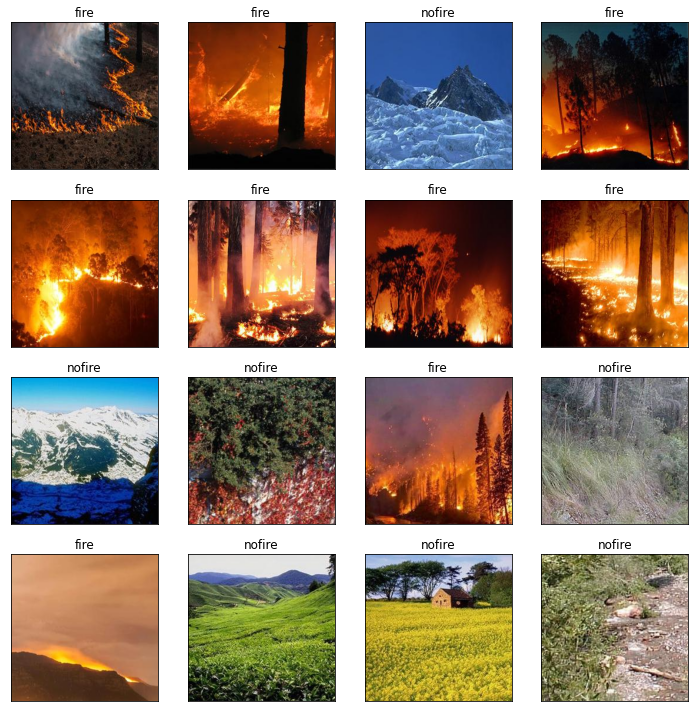

In [11]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axis = plt.subplots(nrows = 4, 
                         ncols = 4, 
                         figsize = (10, 10), 
                         subplot_kw = {'xticks' : [], 'yticks' : []})
for i, ax in enumerate(axis.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [12]:
test_dir = r'C:\Users\DELL\Desktop\python project\Deep Learning\Wildfire Detection\forest_fire\Testing'
train_dir = r'C:\Users\DELL\Desktop\python project\Deep Learning\Wildfire Detection\forest_fire\Training and Validation'

In [13]:
train_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input,
    validation_split = 0.2
)
test_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input
)

In [14]:
train_image = train_generator.flow_from_directory(r'C:\Users\DELL\Desktop\python project\Deep Learning\Wildfire Detection\forest_fire\Training and Validation',
                                                   target_size = IMAGE_SIZE,
                                                   batch_size = BATCH_SIZE,
                                                   color_mode = 'rgb',
                                                   class_mode = 'categorical',
                                                   shuffle = True,
                                                   seed = 42,
                                                   subset = 'training')

Found 1467 images belonging to 2 classes.


In [15]:
valid_image = train_generator.flow_from_directory(r'C:\Users\DELL\Desktop\python project\Deep Learning\Wildfire Detection\forest_fire\Training and Validation',
                                                  target_size = IMAGE_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  color_mode = 'rgb',
                                                  class_mode = 'categorical',
                                                  seed = 42,
                                                  shuffle = True, 
                                                  subset = 'validation')

Found 365 images belonging to 2 classes.


In [16]:
test_image = test_generator.flow_from_directory(r'C:\Users\DELL\Desktop\python project\Deep Learning\Wildfire Detection\forest_fire\Testing',
                                                target_size = IMAGE_SIZE, 
                                                batch_size = BATCH_SIZE, 
                                                class_mode = 'categorical',
                                                color_mode = 'rgb',
                                                shuffle = True,
                                                seed = 42)

Found 68 images belonging to 2 classes.


In [17]:
augment = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(22, 224),
    layers.experimental.preprocessing.Rescaling(1. / 255),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1)
])

In [18]:
model = tf.keras.applications.vgg19.VGG19(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'max'
)
model.trainable = False

In [19]:
checkpoint_path = 'wildfire_classification_chcekpoint'

In [20]:
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only = True,
    monitor = 'val_accuracy',
    save_best_only = True
)

In [21]:
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

In [22]:
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    facor = 0.2,
    patience = 3,
    min_lr = 0.0001
)

In [23]:
inputs = model.input
x = augment(inputs)

x = Dense(128, activation = 'relu')(model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

In [24]:
outputs = Dense(2, activation = 'softmax')(x)

In [25]:
model = Model(inputs = inputs, outputs = outputs)

In [26]:
model.compile(
    optimizer = Adam(0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [27]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

def create_tensorboard_callback(log_dir, experiment_name):
    log_dir = log_dir + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [28]:
history = model.fit(
    train_image,
    steps_per_epoch = len(train_image),
    validation_data = valid_image,
    validation_steps = len(valid_image),
    epochs = 100,
    callbacks = [early_stopping, 
                 create_tensorboard_callback("training_logs", "wildfire_classification"),
                 checkpoint_callback,
                 reduce_lr]
)

Saving TensorBoard log files to: training_logs/wildfire_classification/20230514-064247
Epoch 1/100
46/46 [==============================] - 1432s 31s/step - loss: 0.2342 - accuracy: 0.8943 - val_loss: 0.1276 - val_accuracy: 0.9699 - lr: 0.0010
Epoch 2/100
46/46 [==============================] - 1396s 30s/step - loss: 0.0527 - accuracy: 0.9741 - val_loss: 0.0760 - val_accuracy: 0.9836 - lr: 0.0010
Epoch 3/100
46/46 [==============================] - 1388s 30s/step - loss: 0.0371 - accuracy: 0.9843 - val_loss: 0.0750 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 4/100
46/46 [==============================] - 1364s 30s/step - loss: 0.0315 - accuracy: 0.9884 - val_loss: 0.0819 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 5/100
46/46 [==============================] - 1359s 30s/step - loss: 0.0231 - accuracy: 0.9918 - val_loss: 0.0856 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 6/100
46/46 [==============================] - 1366s 30s/step - loss: 0.0352 - accuracy: 0.9884 - val_loss: 0.0915 - val_a

In [30]:
results = model.evaluate(test_image, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.06901
Test Accuracy: 97.06%


In [51]:
model.save('model_VGG19.h5')

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

<Figure size 432x288 with 0 Axes>

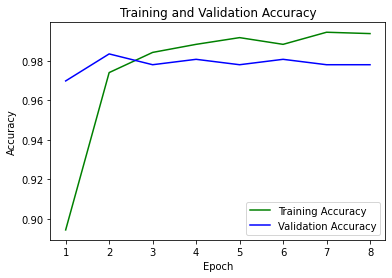

<Figure size 432x288 with 0 Axes>

In [33]:
#accuracy
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

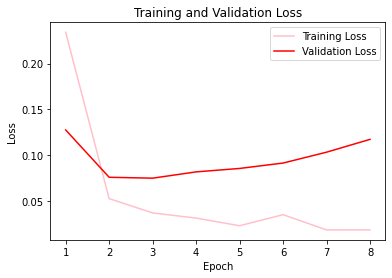

In [34]:
# Loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

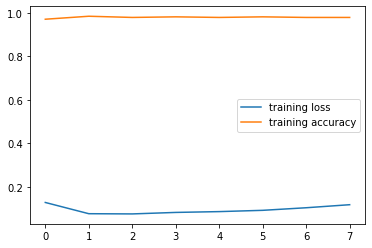

In [35]:
plt.plot(history.history['val_loss'], label = 'training loss')
plt.plot(history.history['val_accuracy'], label = 'training accuracy')
plt.legend()

In [36]:
pred = model.predict(test_image)
pred = np.argmax(pred,axis=1)

3/3 [==============================] - 59s 15s/step


In [37]:
labels = (train_image.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

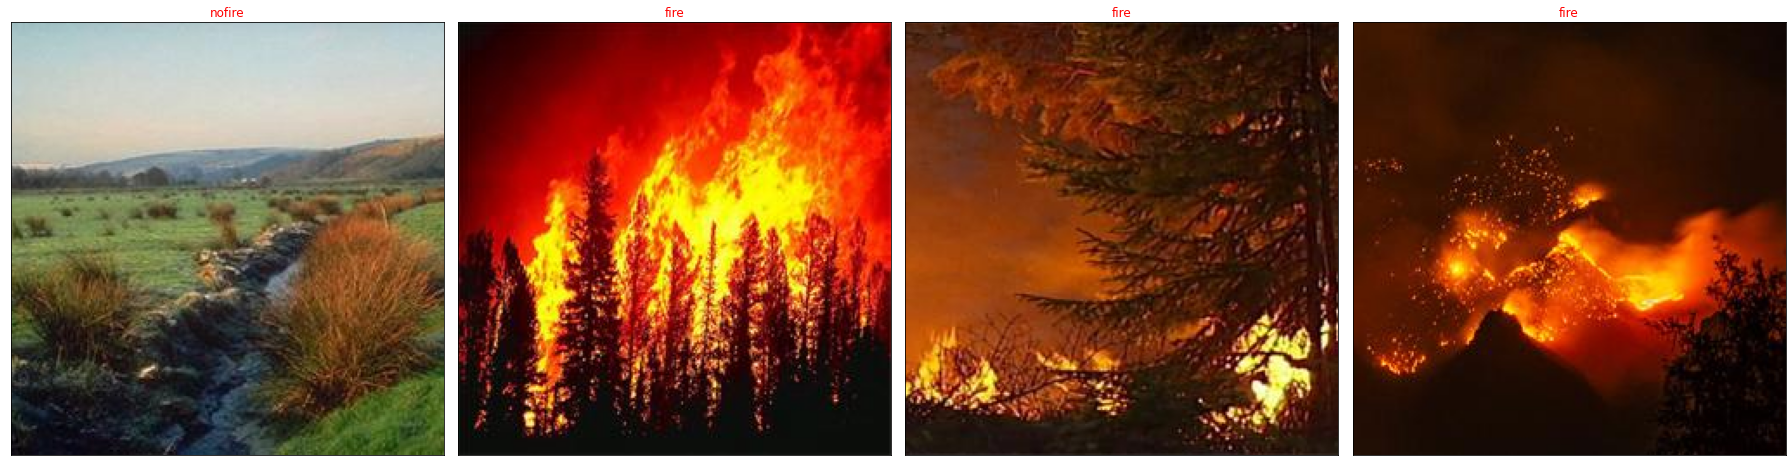

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 15), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath.iloc[random_index[i]]))
    if random_index[i] < len(pred) and image_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(image_df.Label.iloc[random_index[i]], color=color)

plt.tight_layout()
plt.show()